In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Chatbot Tutorial
**Author:** [Matthew Inkawhich](https://github.com/MatthewInkawhich)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this tutorial, we explore a fun and interesting use-case of recurrent
sequence-to-sequence models. We will train a simple chatbot using movie
scripts from the [Cornell Movie-Dialogs
Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)_.

Conversational models are a hot topic in artificial intelligence
research. Chatbots can be found in a variety of settings, including
customer service applications and online helpdesks. These bots are often
powered by retrieval-based models, which output predefined responses to
questions of certain forms. In a highly restricted domain like a
company’s IT helpdesk, these models may be sufficient, however, they are
not robust enough for more general use-cases. Teaching a machine to
carry out a meaningful conversation with a human in multiple domains is
a research question that is far from solved. Recently, the deep learning
boom has allowed for powerful generative models like Google’s [Neural
Conversational Model](https://arxiv.org/abs/1506.05869)_, which marks
a large step towards multi-domain generative conversational models. In
this tutorial, we will implement this kind of model in PyTorch.

.. figure:: /_static/img/chatbot/bot.png
   :align: center
   :alt: bot

.. code:: python

  > hello?
  Bot: hello .
  > where am I?
  Bot: you re in a hospital .
  > who are you?
  Bot: i m a lawyer .
  > how are you doing?
  Bot: i m fine .
  > are you my friend?
  Bot: no .
  > you're under arrest
  Bot: i m trying to help you !
  > i'm just kidding
  Bot: i m sorry .
  > where are you from?
  Bot: san francisco .
  > it's time for me to leave
  Bot: i know .
  > goodbye
  Bot: goodbye .

**Tutorial Highlights**

-  Handle loading and preprocessing of [Cornell Movie-Dialogs
   Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)_
   dataset
-  Implement a sequence-to-sequence model with [Luong attention
   mechanism(s)](https://arxiv.org/abs/1508.04025)_
-  Jointly train encoder and decoder models using mini-batches
-  Implement greedy-search decoding module
-  Interact with trained chatbot

**Acknowledgements**

This tutorial borrows code from the following sources:

1) Yuan-Kuei Wu’s pytorch-chatbot implementation:
   https://github.com/ywk991112/pytorch-chatbot

2) Sean Robertson’s practical-pytorch seq2seq-translation example:
   https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation

3) FloydHub’s Cornell Movie Corpus preprocessing code:
   https://github.com/floydhub/textutil-preprocess-cornell-movie-corpus




## Preparations

To start, Download the data ZIP file
[here](https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip)_



In [4]:
# and put in a ``data/`` directory under the current directory.
#
# After that, let’s import some necessities.
#

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

## Load & Preprocess Data

The next step is to reformat our data file and load the data into
structures that we can work with.

The [Cornell Movie-Dialogs
Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)_
is a rich dataset of movie character dialog:

-  220,579 conversational exchanges between 10,292 pairs of movie
   characters
-  9,035 characters from 617 movies
-  304,713 total utterances

This dataset is large and diverse, and there is a great variation of
language formality, time periods, sentiment, etc. Our hope is that this
diversity makes our model robust to many forms of inputs and queries.

First, we’ll take a look at some lines of our datafile to see the
original format.




In [5]:
corpus_name = "movie-corpus"
corpus = os.path.join("/content/drive/MyDrive/data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

### Create formatted data file

For convenience, we'll create a nicely formatted data file in which each line
contains a tab-separated *query sentence* and a *response sentence* pair.

The following functions facilitate the parsing of the raw
*utterances.jsonl* data file.

-  ``loadLinesAndConversations`` splits each line of the file into a dictionary of
   lines with fields: lineID, characterID, and text and then groups them
   into conversations with fields: conversationID, movieID, and lines.
-  ``extractSentencePairs`` extracts pairs of sentences from
   conversations




In [6]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

Now we’ll call these functions and create the file. We’ll call it
*formatted_movie_lines.txt*.




In [7]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


### Load and trim data

Our next order of business is to create a vocabulary and load
query/response sentence pairs into memory.

Note that we are dealing with sequences of **words**, which do not have
an implicit mapping to a discrete numerical space. Thus, we must create
one by mapping each unique word that we encounter in our dataset to an
index value.

For this we define a ``Voc`` class, which keeps a mapping from words to
indexes, a reverse mapping of indexes to words, a count of each word and
a total word count. The class provides methods for adding a word to the
vocabulary (``addWord``), adding all words in a sentence
(``addSentence``) and trimming infrequently seen words (``trim``). More
on trimming later.




In [8]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Now we can assemble our vocabulary and query/response sentence pairs.
Before we are ready to use this data, we must perform some
preprocessing.

First, we must convert the Unicode strings to ASCII using
``unicodeToAscii``. Next, we should convert all letters to lowercase and
trim all non-letter characters except for basic punctuation
(``normalizeString``). Finally, to aid in training convergence, we will
filter out sentences with length greater than the ``MAX_LENGTH``
threshold (``filterPairs``).




In [9]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


Another tactic that is beneficial to achieving faster convergence during
training is trimming rarely used words out of our vocabulary. Decreasing
the feature space will also soften the difficulty of the function that
the model must learn to approximate. We will do this as a two-step
process:

1) Trim words used under ``MIN_COUNT`` threshold using the ``voc.trim``
   function.

2) Filter out pairs with trimmed words.




In [10]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


## Prepare Data for Models

Although we have put a great deal of effort into preparing and massaging our
data into a nice vocabulary object and list of sentence pairs, our models
will ultimately expect numerical torch tensors as inputs. One way to
prepare the processed data for the models can be found in the [seq2seq
translation
tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)_.
In that tutorial, we use a batch size of 1, meaning that all we have to
do is convert the words in our sentence pairs to their corresponding
indexes from the vocabulary and feed this to the models.

However, if you’re interested in speeding up training and/or would like
to leverage GPU parallelization capabilities, you will need to train
with mini-batches.

Using mini-batches also means that we must be mindful of the variation
of sentence length in our batches. To accommodate sentences of different
sizes in the same batch, we will make our batched input tensor of shape
*(max_length, batch_size)*, where sentences shorter than the
*max_length* are zero padded after an *EOS_token*.

If we simply convert our English sentences to tensors by converting
words to their indexes(\ ``indexesFromSentence``) and zero-pad, our
tensor would have shape *(batch_size, max_length)* and indexing the
first dimension would return a full sequence across all time-steps.
However, we need to be able to index our batch along time, and across
all sequences in the batch. Therefore, we transpose our input batch
shape to *(max_length, batch_size)*, so that indexing across the first
dimension returns a time step across all sentences in the batch. We
handle this transpose implicitly in the ``zeroPadding`` function.

.. figure:: /_static/img/chatbot/seq2seq_batches.png
   :align: center
   :alt: batches

The ``inputVar`` function handles the process of converting sentences to
tensor, ultimately creating a correctly shaped zero-padded tensor. It
also returns a tensor of ``lengths`` for each of the sequences in the
batch which will be passed to our decoder later.

The ``outputVar`` function performs a similar function to ``inputVar``,
but instead of returning a ``lengths`` tensor, it returns a binary mask
tensor and a maximum target sentence length. The binary mask tensor has
the same shape as the output target tensor, but every element that is a
*PAD_token* is 0 and all others are 1.

``batch2TrainData`` simply takes a bunch of pairs and returns the input
and target tensors using the aforementioned functions.




In [11]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  19,   14,   24,  789,   54],
        [  69,   14,  449,   59, 4968],
        [  24, 2146,  609,   10,   14],
        [  83,   28, 3109,    2,    2],
        [  28,  819,   14,    0,    0],
        [  72,   14,    2,    0,    0],
        [ 317,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([8, 7, 6, 4, 4])
target_variable: tensor([[ 296,   35,   36,   96,  780],
        [  11,   18,   17,   14, 4801],
        [ 246,  484,   37,    2,   14],
        [ 135,  132,   11,    0,    2],
        [  83,  222,  355,    0,    0],
        [  28,   84,   94,    0,    0],
        [  24,   85,    6,    0,    0],
        [ 126,   14,    2,    0,    0],
        [  14,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True],
        [ True,  True,  Tr

## Define Models

### Seq2Seq Model

The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The
goal of a seq2seq model is to take a variable-length sequence as an
input, and return a variable-length sequence as an output using a
fixed-sized model.

[Sutskever et al.](https://arxiv.org/abs/1409.3215)_ discovered that
by using two separate recurrent neural nets together, we can accomplish
this task. One RNN acts as an **encoder**, which encodes a variable
length input sequence to a fixed-length context vector. In theory, this
context vector (the final hidden layer of the RNN) will contain semantic
information about the query sentence that is input to the bot. The
second RNN is a **decoder**, which takes an input word and the context
vector, and returns a guess for the next word in the sequence and a
hidden state to use in the next iteration.

.. figure:: /_static/img/chatbot/seq2seq_ts.png
   :align: center
   :alt: model

Image source:
https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/




### Encoder

The encoder RNN iterates through the input sentence one token
(e.g. word) at a time, at each time step outputting an “output” vector
and a “hidden state” vector. The hidden state vector is then passed to
the next time step, while the output vector is recorded. The encoder
transforms the context it saw at each point in the sequence into a set
of points in a high-dimensional space, which the decoder will use to
generate a meaningful output for the given task.

At the heart of our encoder is a multi-layered Gated Recurrent Unit,
invented by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf)_ in
2014. We will use a bidirectional variant of the GRU, meaning that there
are essentially two independent RNNs: one that is fed the input sequence
in normal sequential order, and one that is fed the input sequence in
reverse order. The outputs of each network are summed at each time step.
Using a bidirectional GRU will give us the advantage of encoding both
past and future contexts.

Bidirectional RNN:

.. figure:: /_static/img/chatbot/RNN-bidirectional.png
   :width: 70%
   :align: center
   :alt: rnn_bidir

Image source: https://colah.github.io/posts/2015-09-NN-Types-FP/

Note that an ``embedding`` layer is used to encode our word indices in
an arbitrarily sized feature space. For our models, this layer will map
each word to a feature space of size *hidden_size*. When trained, these
values should encode semantic similarity between similar meaning words.

Finally, if passing a padded batch of sequences to an RNN module, we
must pack and unpack padding around the RNN pass using
``nn.utils.rnn.pack_padded_sequence`` and
``nn.utils.rnn.pad_packed_sequence`` respectively.

**Computation Graph:**

   1) Convert word indexes to embeddings.
   2) Pack padded batch of sequences for RNN module.
   3) Forward pass through GRU.
   4) Unpack padding.
   5) Sum bidirectional GRU outputs.
   6) Return output and final hidden state.

**Inputs:**

-  ``input_seq``: batch of input sentences; shape=\ *(max_length,
   batch_size)*
-  ``input_lengths``: list of sentence lengths corresponding to each
   sentence in the batch; shape=\ *(batch_size)*
-  ``hidden``: hidden state; shape=\ *(n_layers x num_directions,
   batch_size, hidden_size)*

**Outputs:**

-  ``outputs``: output features from the last hidden layer of the GRU
   (sum of bidirectional outputs); shape=\ *(max_length, batch_size,
   hidden_size)*
-  ``hidden``: updated hidden state from GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*





In [12]:

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    #@torch.jit.script_method
    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden





### Decoder

The decoder RNN generates the response sentence in a token-by-token
fashion. It uses the encoder’s context vectors, and internal hidden
states to generate the next word in the sequence. It continues
generating words until it outputs an *EOS_token*, representing the end
of the sentence. A common problem with a vanilla seq2seq decoder is that
if we rely solely on the context vector to encode the entire input
sequence’s meaning, it is likely that we will have information loss.
This is especially the case when dealing with long input sequences,
greatly limiting the capability of our decoder.

To combat this, [Bahdanau et al.](https://arxiv.org/abs/1409.0473)_
created an “attention mechanism” that allows the decoder to pay
attention to certain parts of the input sequence, rather than using the
entire fixed context at every step.

At a high level, attention is calculated using the decoder’s current
hidden state and the encoder’s outputs. The output attention weights
have the same shape as the input sequence, allowing us to multiply them
by the encoder outputs, giving us a weighted sum which indicates the
parts of encoder output to pay attention to. [Sean
Robertson’s](https://github.com/spro)_ figure describes this very
well:

.. figure:: /_static/img/chatbot/attn2.png
   :align: center
   :alt: attn2

[Luong et al.](https://arxiv.org/abs/1508.04025)_ improved upon
Bahdanau et al.’s groundwork by creating “Global attention”. The key
difference is that with “Global attention”, we consider all of the
encoder’s hidden states, as opposed to Bahdanau et al.’s “Local
attention”, which only considers the encoder’s hidden state from the
current time step. Another difference is that with “Global attention”,
we calculate attention weights, or energies, using the hidden state of
the decoder from the current time step only. Bahdanau et al.’s attention
calculation requires knowledge of the decoder’s state from the previous
time step. Also, Luong et al. provides various methods to calculate the
attention energies between the encoder output and decoder output which
are called “score functions”:

.. figure:: /_static/img/chatbot/scores.png
   :width: 60%
   :align: center
   :alt: scores

where $h_t$ = current target decoder state and $\bar{h}_s$ =
all encoder states.

Overall, the Global attention mechanism can be summarized by the
following figure. Note that we will implement the “Attention Layer” as a
separate ``nn.Module`` called ``Attn``. The output of this module is a
softmax normalized weights tensor of shape *(batch_size, 1,
max_length)*.

.. figure:: /_static/img/chatbot/global_attn.png
   :align: center
   :width: 60%
   :alt: global_attn




In [13]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

Now that we have defined our attention submodule, we can implement the
actual decoder model. For the decoder, we will manually feed our batch
one time step at a time. This means that our embedded word tensor and
GRU output will both have shape *(1, batch_size, hidden_size)*.

**Computation Graph:**

   1) Get embedding of current input word.
   2) Forward through unidirectional GRU.
   3) Calculate attention weights from the current GRU output from (2).
   4) Multiply attention weights to encoder outputs to get new "weighted sum" context vector.
   5) Concatenate weighted context vector and GRU output using Luong eq. 5.
   6) Predict next word using Luong eq. 6 (without softmax).
   7) Return output and final hidden state.

**Inputs:**

-  ``input_step``: one time step (one word) of input sequence batch;
   shape=\ *(1, batch_size)*
-  ``last_hidden``: final hidden layer of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*
-  ``encoder_outputs``: encoder model’s output; shape=\ *(max_length,
   batch_size, hidden_size)*

**Outputs:**

-  ``output``: softmax normalized tensor giving probabilities of each
   word being the correct next word in the decoded sequence;
   shape=\ *(batch_size, voc.num_words)*
-  ``hidden``: final hidden state of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*




In [14]:

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)
        
    #@torch.jit.script_method
    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

## Define Training Procedure

### Masked loss

Since we are dealing with batches of padded sequences, we cannot simply
consider all elements of the tensor when calculating loss. We define
``maskNLLLoss`` to calculate our loss based on our decoder’s output
tensor, the target tensor, and a binary mask tensor describing the
padding of the target tensor. This loss function calculates the average
negative log likelihood of the elements that correspond to a *1* in the
mask tensor.




In [15]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

### Single training iteration

The ``train`` function contains the algorithm for a single training
iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

-  The first trick is using **teacher forcing**. This means that at some
   probability, set by ``teacher_forcing_ratio``, we use the current
   target word as the decoder’s next input rather than using the
   decoder’s current guess. This technique acts as training wheels for
   the decoder, aiding in more efficient training. However, teacher
   forcing can lead to model instability during inference, as the
   decoder may not have a sufficient chance to truly craft its own
   output sequences during training. Thus, we must be mindful of how we
   are setting the ``teacher_forcing_ratio``, and not be fooled by fast
   convergence.

-  The second trick that we implement is **gradient clipping**. This is
   a commonly used technique for countering the “exploding gradient”
   problem. In essence, by clipping or thresholding gradients to a
   maximum value, we prevent the gradients from growing exponentially
   and either overflow (NaN), or overshoot steep cliffs in the cost
   function.

.. figure:: /_static/img/chatbot/grad_clip.png
   :align: center
   :width: 60%
   :alt: grad_clip

Image source: Goodfellow et al. *Deep Learning*. 2016. https://www.deeplearningbook.org/

**Sequence of Operations:**

   1) Forward pass entire input batch through encoder.
   2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
   3) Forward input batch sequence through decoder one time step at a time.
   4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
   5) Calculate and accumulate loss.
   6) Perform backpropagation.
   7) Clip gradients.
   8) Update encoder and decoder model parameters.


.. Note ::

  PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
  other non-recurrent layers by simply passing them the entire input
  sequence (or batch of sequences). We use the ``GRU`` layer like this in
  the ``encoder``. The reality is that under the hood, there is an
  iterative process looping over each time step calculating hidden states.
  Alternatively, you can run these modules one time-step at a time. In
  this case, we manually loop over the sequences during the training
  process like we must do for the ``decoder`` model. As long as you
  maintain the correct conceptual model of these modules, implementing
  sequential models can be very straightforward.





In [16]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

### Training iterations

It is finally time to tie the full training procedure together with the
data. The ``trainIters`` function is responsible for running
``n_iterations`` of training given the passed models, optimizers, data,
etc. This function is quite self explanatory, as we have done the heavy
lifting with the ``train`` function.

One thing to note is that when we save our model, we save a tarball
containing the encoder and decoder state_dicts (parameters), the
optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
in this way will give us the ultimate flexibility with the checkpoint.
After loading a checkpoint, we will be able to use the model parameters
to run inference, or we can continue training right where we left off.




In [17]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    total_loss = 0
    itr_counter = 0
    for iteration in range(start_iteration, n_iteration + 1):
        itr_counter += 1
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        total_loss += loss
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return(total_loss/itr_counter)




## Define Evaluation

After training a model, we want to be able to talk to the bot ourselves.
First, we must define how we want the model to decode the encoded input.

### Greedy decoding

Greedy decoding is the decoding method that we use during training when
we are **NOT** using teacher forcing. In other words, for each time
step, we simply choose the word from ``decoder_output`` with the highest
softmax value. This decoding method is optimal on a single time-step
level.

To facilitate the greedy decoding operation, we define a
``GreedySearchDecoder`` class. When run, an object of this class takes
an input sequence (``input_seq``) of shape *(input_seq length, 1)*, a
scalar input length (``input_length``) tensor, and a ``max_length`` to
bound the response sentence length. The input sentence is evaluated
using the following computational graph:

**Computation Graph:**

   1) Forward input through encoder model.
   2) Prepare encoder's final hidden layer to be first hidden input to the decoder.
   3) Initialize decoder's first input as SOS_token.
   4) Initialize tensors to append decoded words to.
   5) Iteratively decode one word token at a time:
       a) Forward pass through decoder.
       b) Obtain most likely word token and its softmax score.
       c) Record token and score.
       d) Prepare current token to be next decoder input.
   6) Return collections of word tokens and scores.




In [18]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

### Evaluate my text

Now that we have our decoding method defined, we can write functions for
evaluating a string input sentence. The ``evaluate`` function manages
the low-level process of handling the input sentence. We first format
the sentence as an input batch of word indexes with *batch_size==1*. We
do this by converting the words of the sentence to their corresponding
indexes, and transposing the dimensions to prepare the tensor for our
models. We also create a ``lengths`` tensor which contains the length of
our input sentence. In this case, ``lengths`` is scalar because we are
only evaluating one sentence at a time (batch_size==1). Next, we obtain
the decoded response sentence tensor using our ``GreedySearchDecoder``
object (``searcher``). Finally, we convert the response’s indexes to
words and return the list of decoded words.

``evaluateInput`` acts as the user interface for our chatbot. When
called, an input text field will spawn in which we can enter our query
sentence. After typing our input sentence and pressing *Enter*, our text
is normalized in the same way as our training data, and is ultimately
fed to the ``evaluate`` function to obtain a decoded output sentence. We
loop this process, so we can keep chatting with our bot until we enter
either “q” or “quit”.

Finally, if a sentence is entered that contains a word that is not in
the vocabulary, we handle this gracefully by printing an error message
and prompting the user to enter another sentence.




In [19]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

## Run Model

Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we
must initialize the individual encoder and decoder models. In the
following block, we set our desired configurations, choose to start from
scratch or set a checkpoint to load from, and build and initialize the
models. Feel free to play with different model configurations to
optimize performance.




In [ ]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


### Run Training

Run the following block if you want to train the model.

First we set training parameters, then we initialize our optimizers, and
finally we call the ``trainIters`` function to run our training
iterations.




In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9737
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8443
Iteration: 3; Percent complete: 0.1%; Average loss: 8.6283
Iteration: 4; Percent complete: 0.1%; Average loss: 8.3634
Iteration: 5; Percent complete: 0.1%; Average loss: 7.8782
Iteration: 6; Percent complete: 0.1%; Average loss: 7.2911
Iteration: 7; Percent complete: 0.2%; Average loss: 6.7550
Iteration: 8; Percent complete: 0.2%; Average loss: 6.9870
Iteration: 9; Percent complete: 0.2%; Average loss: 6.8889
Iteration: 10; Percent complete: 0.2%; Average loss: 6.3766
Iteration: 11; Percent complete: 0.3%; Average loss: 6.2924
Iteration: 12; Percent complete: 0.3%; Average loss: 5.9520
Iteration: 13; Percent complete: 0.3%; Average loss: 5.8781
Iteration: 14; Percent complete: 0.4%; Average loss: 5.5389
Iteration: 15; Percent complete: 0.4%; Average loss: 5.4942
Iteration: 16; Percent complete: 0.4%

3.2314426802895784

### Run Evaluation

To chat with your model, run the following block.




In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> hi
Bot: hi . s late . .
> quit


## Conclusion

That’s all for this one, folks. Congratulations, you now know the
fundamentals to building a generative chatbot model! If you’re
interested, you can try tailoring the chatbot’s behavior by tweaking the
model and training parameters and customizing the data that you train
the model on.

Check out the other tutorials for more cool deep learning applications
in PyTorch!




***Q.3, Q.4***

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb

In [ ]:
# Log in to your W&B account

wandb.login()

wandb: Currently logged in as: rs8385 (rithviik). Use `wandb login --relogin` to force relogin


True

In [ ]:
sweep_config = {
    "name": "hyperparameter_sweep",
    'metric': {'goal': 'minimize', 'name': 'loss'},
    "method": "random",
    "parameters": {
  
        "learning_rate": {
            "values": [0.0001, 0.00025, 0.0005, 0.001]
        },
        "optimizer": {
            "values": ["adam", "sgd"]
        },
        "clip": {
            "values": [0, 25, 50, 100]
        },
        "teacher_forcing_ratio": {
            "values": [0, 0.5, 1.0]
        },
        "decoder_learning_ratio": {
            "values": [1.0, 3.0, 5.0, 10.0]
        }
    }
}
# Configure models
model_name = 'cb_model_wandb'
attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64


def wandb_train():  
    # Initialize a new WandB run
    wandb.init()


    # Set the hyperparameters for this run
    config = wandb.config
    config.learning_rate = sweep_config['parameters']['learning_rate']
    config.optimizer = sweep_config['parameters']['optimizer']
    config.clip = sweep_config['parameters']['clip']
    config.teacher_forcing_ratio = sweep_config['parameters']['teacher_forcing_ratio']
    config.decoder_learning_ratio = sweep_config['parameters']['decoder_learning_ratio']

   
   # Use the hyperparameters passed from the sweep
    learning_rate = config.learning_rate
    optimizer = config.optimizer
    clip = config.clip
    teacher_forcing_ratio = config.teacher_forcing_ratio
    decoder_learning_ratio = config.decoder_learning_ratio

    print('Building encoder and decoder ...')
    # Initialize word embeddings
    embedding = nn.Embedding(voc.num_words, hidden_size)
   
    # Initialize encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
   
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    print('Models built and ready to go!')



    n_iteration = 4000
    print_every = 4000
    save_every=500
    loadFilename=None

    # Ensure dropout layers are in train mode
    encoder.train()
    decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    if config.optimizer == 'adam':
      encoder_optimizer = optim.Adam(encoder.parameters(), lr=config.learning_rate)
      decoder_optimizer = optim.Adam(decoder.parameters(), lr=config.learning_rate * config.decoder_learning_ratio)
    else:
      encoder_optimizer = optim.SGD(encoder.parameters(), lr=config.learning_rate)
      decoder_optimizer = optim.SGD(decoder.parameters(), lr=config.learning_rate * config.decoder_learning_ratio)


    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()


    # Run training iterations
    print("Starting Training!")
    loss = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
              embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
              print_every, save_every, config.clip, corpus_name, loadFilename)

    # Log the loss and hyperparameters for this run
    wandb.log({'loss': loss})


    # Finish the WandB run
    wandb.finish()
  


#Initialize a new sweep
sweep_id = wandb.sweep(sweep_config, project='chatbot')

# Run the sweep
wandb.agent(sweep_id, function=wandb_train, count=50)



Create sweep with ID: sb7ajiux
Sweep URL: https://wandb.ai/rithviik/chatbot/sweeps/sb7ajiux


wandb: Agent Starting Run: homdgrzd with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.2215


loss,▁
loss,5.22151


wandb: Agent Starting Run: zh4yzjnq with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.2243


loss,▁
loss,5.22426


wandb: Agent Starting Run: 0ck00r8p with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9793


loss,▁
loss,8.97933


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p8ijj3yr with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.1368


loss,▁
loss,4.13678


wandb: Agent Starting Run: r6fdgues with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.4780


loss,▁
loss,5.47797


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1t06f51 with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.4295


loss,▁
loss,5.42953


wandb: Agent Starting Run: 738qrzbc with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.1495


loss,▁
loss,4.14949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q33fk9rs with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.7025


loss,▁
loss,4.70245


wandb: Agent Starting Run: lgyqxjps with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.7185


loss,▁
loss,4.7185


wandb: Agent Starting Run: 8hxp7j7b with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.3595


loss,▁
loss,5.35952


wandb: Agent Starting Run: 83pmnz69 with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.9008


loss,▁
loss,3.90075


wandb: Agent Starting Run: kmwsabya with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: nan


loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: se4mme15 with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.0635


loss,▁
loss,5.06353


wandb: Agent Starting Run: 1nm0luq3 with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.8100


loss,▁
loss,5.80997


wandb: Agent Starting Run: klnpzem2 with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9554


loss,▁
loss,8.9554


wandb: Agent Starting Run: 4pl3xief with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9655


loss,▁
loss,8.96547


wandb: Agent Starting Run: diibred9 with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.6065


loss,▁
loss,4.60646


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sywwiwne with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.0659


loss,▁
loss,4.06593


wandb: Agent Starting Run: 9xrtiep6 with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.1161


loss,▁
loss,4.11608


wandb: Agent Starting Run: fc23mwzz with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.9805


loss,▁
loss,4.98053


wandb: Agent Starting Run: e7enalej with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.2040


loss,▁
loss,4.20396


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9tjebbo with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9751


loss,▁
loss,8.97513


wandb: Agent Starting Run: 32t6907u with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9751


loss,▁
loss,8.9751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vb28wl3p with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.0685


loss,▁
loss,5.06846


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: psfvab1k with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.6988


loss,▁
loss,4.69881


wandb: Agent Starting Run: lcowc915 with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9689


loss,▁
loss,8.96887


wandb: Agent Starting Run: kq2nxmdt with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9696


loss,▁
loss,8.96955


wandb: Agent Starting Run: b9if69rd with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.8940


loss,▁
loss,3.89405


wandb: Agent Starting Run: ynfs1nxr with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9636


loss,▁
loss,8.96365


wandb: Agent Starting Run: ymbktor1 with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9677


loss,▁
loss,8.96773


wandb: Agent Starting Run: 7haotpek with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.8258


loss,▁
loss,5.82581


wandb: Agent Starting Run: k0qaxi02 with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9522


loss,▁
loss,8.95221


wandb: Agent Starting Run: qsdiaw63 with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.7977


loss,▁
loss,5.79768


wandb: Agent Starting Run: bjigbsof with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.1421


loss,▁
loss,5.14209


wandb: Agent Starting Run: 76js92bh with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9588


loss,▁
loss,8.95881


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ddh0ylcn with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9759


loss,▁
loss,8.97592


wandb: Agent Starting Run: 8ybppje1 with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.8954


loss,▁
loss,3.89544


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3r6w2cq4 with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9683


loss,▁
loss,8.96825


wandb: Agent Starting Run: 8leov6vy with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9565


loss,▁
loss,8.95646


wandb: Agent Starting Run: ndzt9oeb with config:
wandb: 	clip: 25
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.8508


loss,▁
loss,4.85077


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8l4ih2pq with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0.5


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9768


loss,▁
loss,8.97678


wandb: Agent Starting Run: 4a04tppn with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.6004


loss,▁
loss,4.60042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rntnsamk with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.4168


loss,▁
loss,4.41678


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zj1ta4us with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.9431


loss,▁
loss,3.9431


wandb: Agent Starting Run: 31rkynjs with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 1
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.1505


loss,▁
loss,4.15049


wandb: Agent Starting Run: mc6lsciq with config:
wandb: 	clip: 0
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 8.9736


loss,▁
loss,8.97357


wandb: Agent Starting Run: 4yglug5f with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 5.1566


loss,▁
loss,5.15657


wandb: Agent Starting Run: ftv3p0xd with config:
wandb: 	clip: 100
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.8958


loss,▁
loss,3.89576


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72dh4vi1 with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 3
wandb: 	learning_rate: 0.00025
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 1


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.9304


loss,▁
loss,3.93039


wandb: Agent Starting Run: 1czqoluu with config:
wandb: 	clip: 50
wandb: 	decoder_learning_ratio: 5
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'clip' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'teacher_forcing_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'decoder_learning_ratio' was locked by 'sweep' (ignored update).


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4000; Percent complete: 100.0%; Average loss: 4.4805


loss,▁
loss,4.4805


**Q.5:**

On seeing the feature importance of W&B, it can be seen that out of all the config parameters, the SGD optimiser had a highest positive correlation of 0.316 with the loss metric. The Adam optimiser instead had a negative correlation of -0.316 with the loss metric. This shows that adam optimiser worked well with the model as the correlation indicates that the higher the correlation, higher the loss metric. We are trying to minimise the loss so a negative correlation indicates better suitability. Also in terms of importance of hyperparameters, the clip has the highest importance and highest negative correlation of -0.723 indicating that it has a major role in determining convergence.  Also following this would be the learning rate and runtime which is also relatively negatively correlated. The other metrics do have a lesser negative correlation and so we can conclude that the primary hyperparameters that brought about convergence are learning rate and clip.
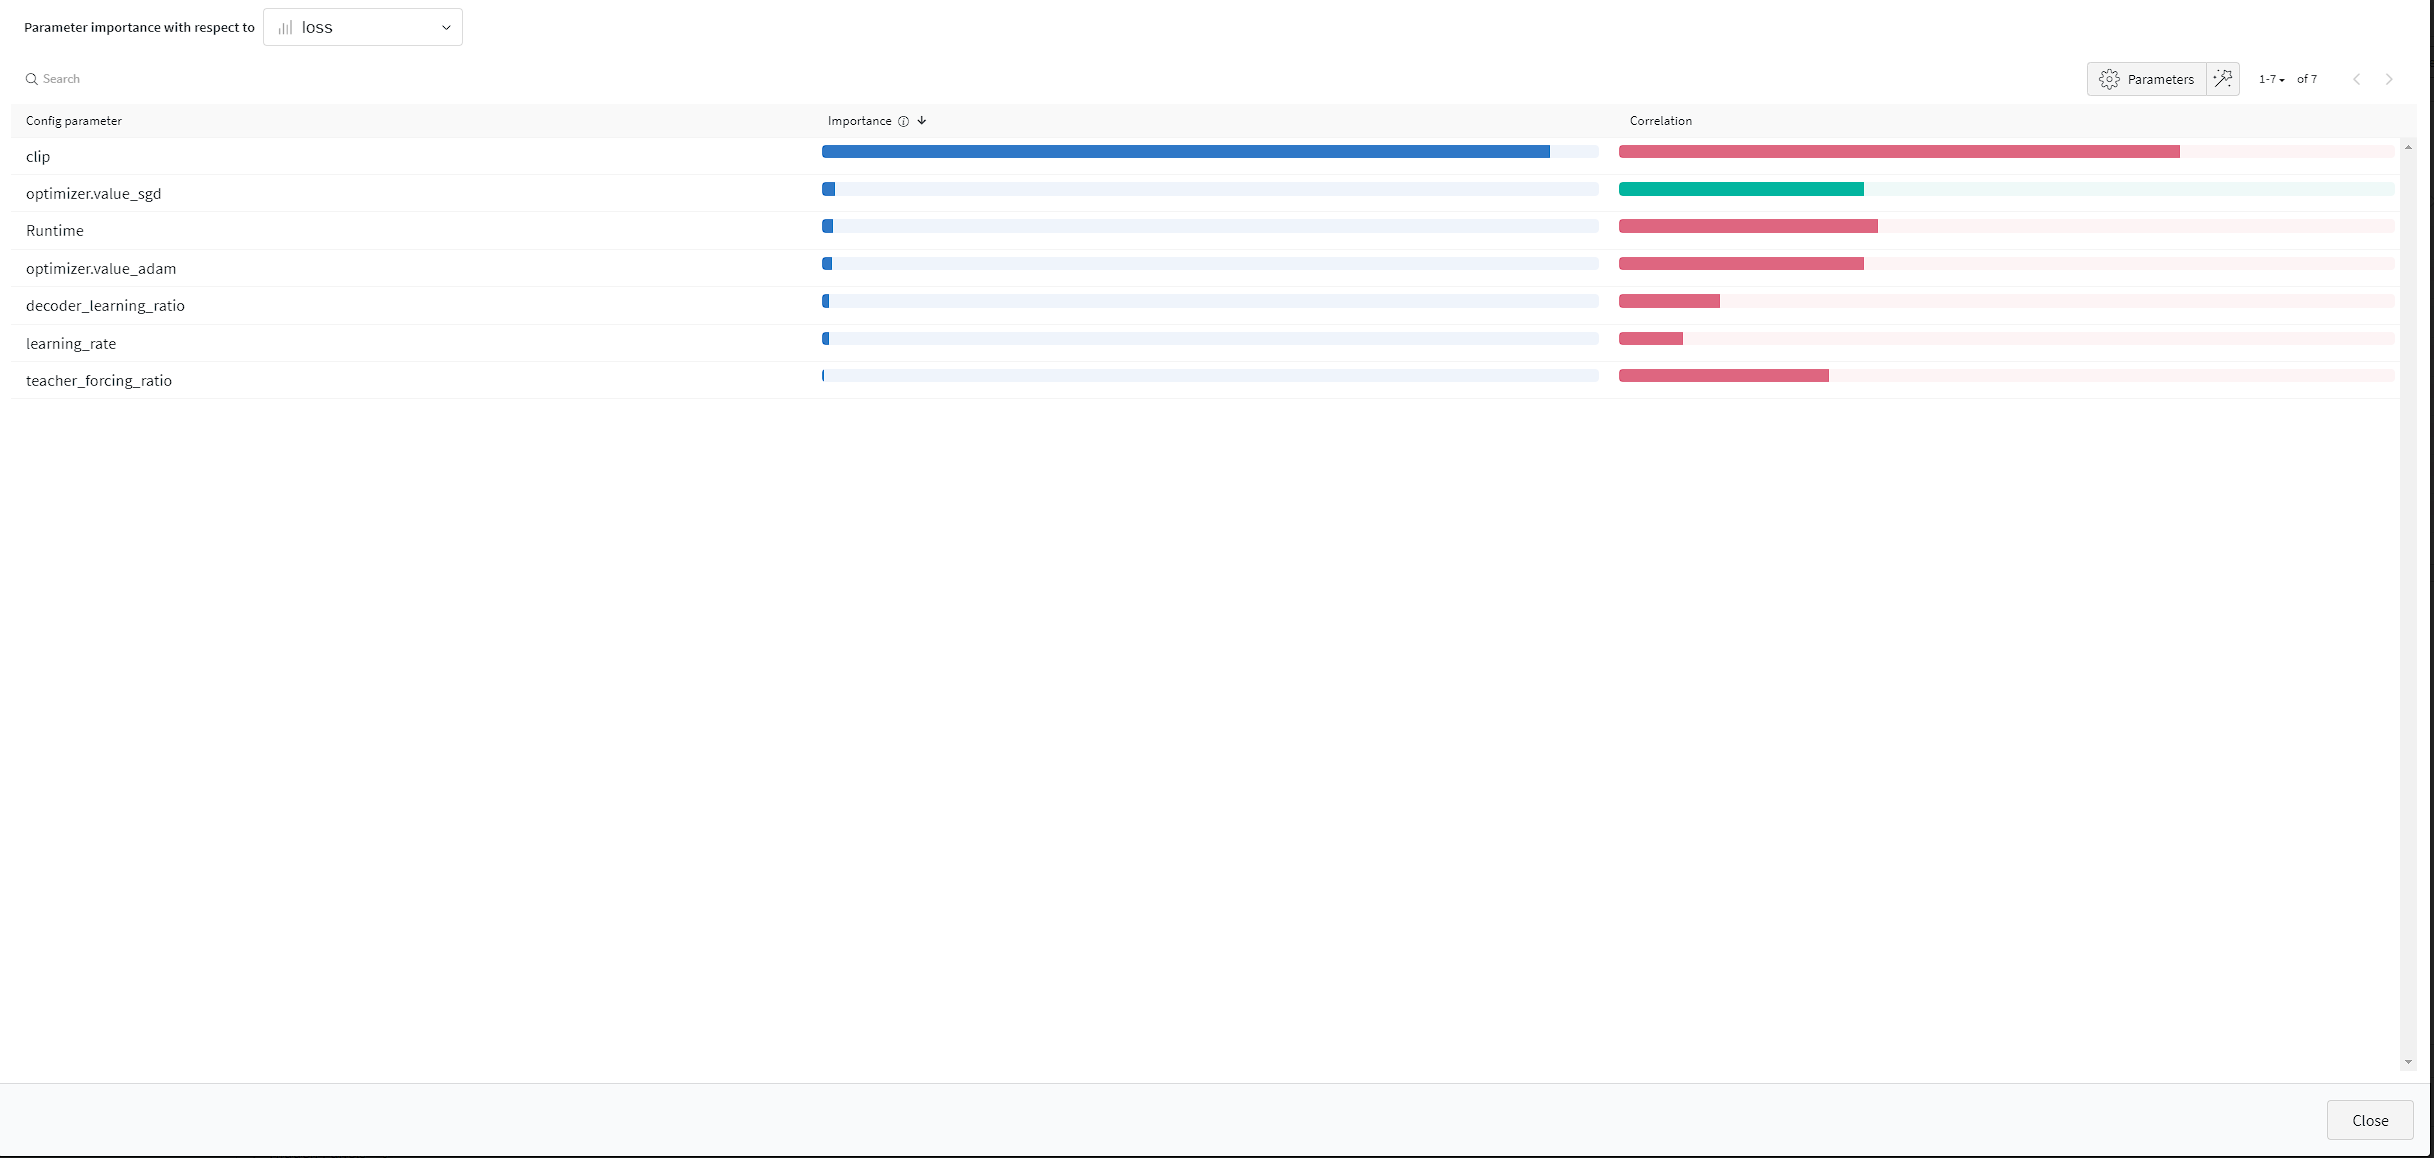

***Loss Log***
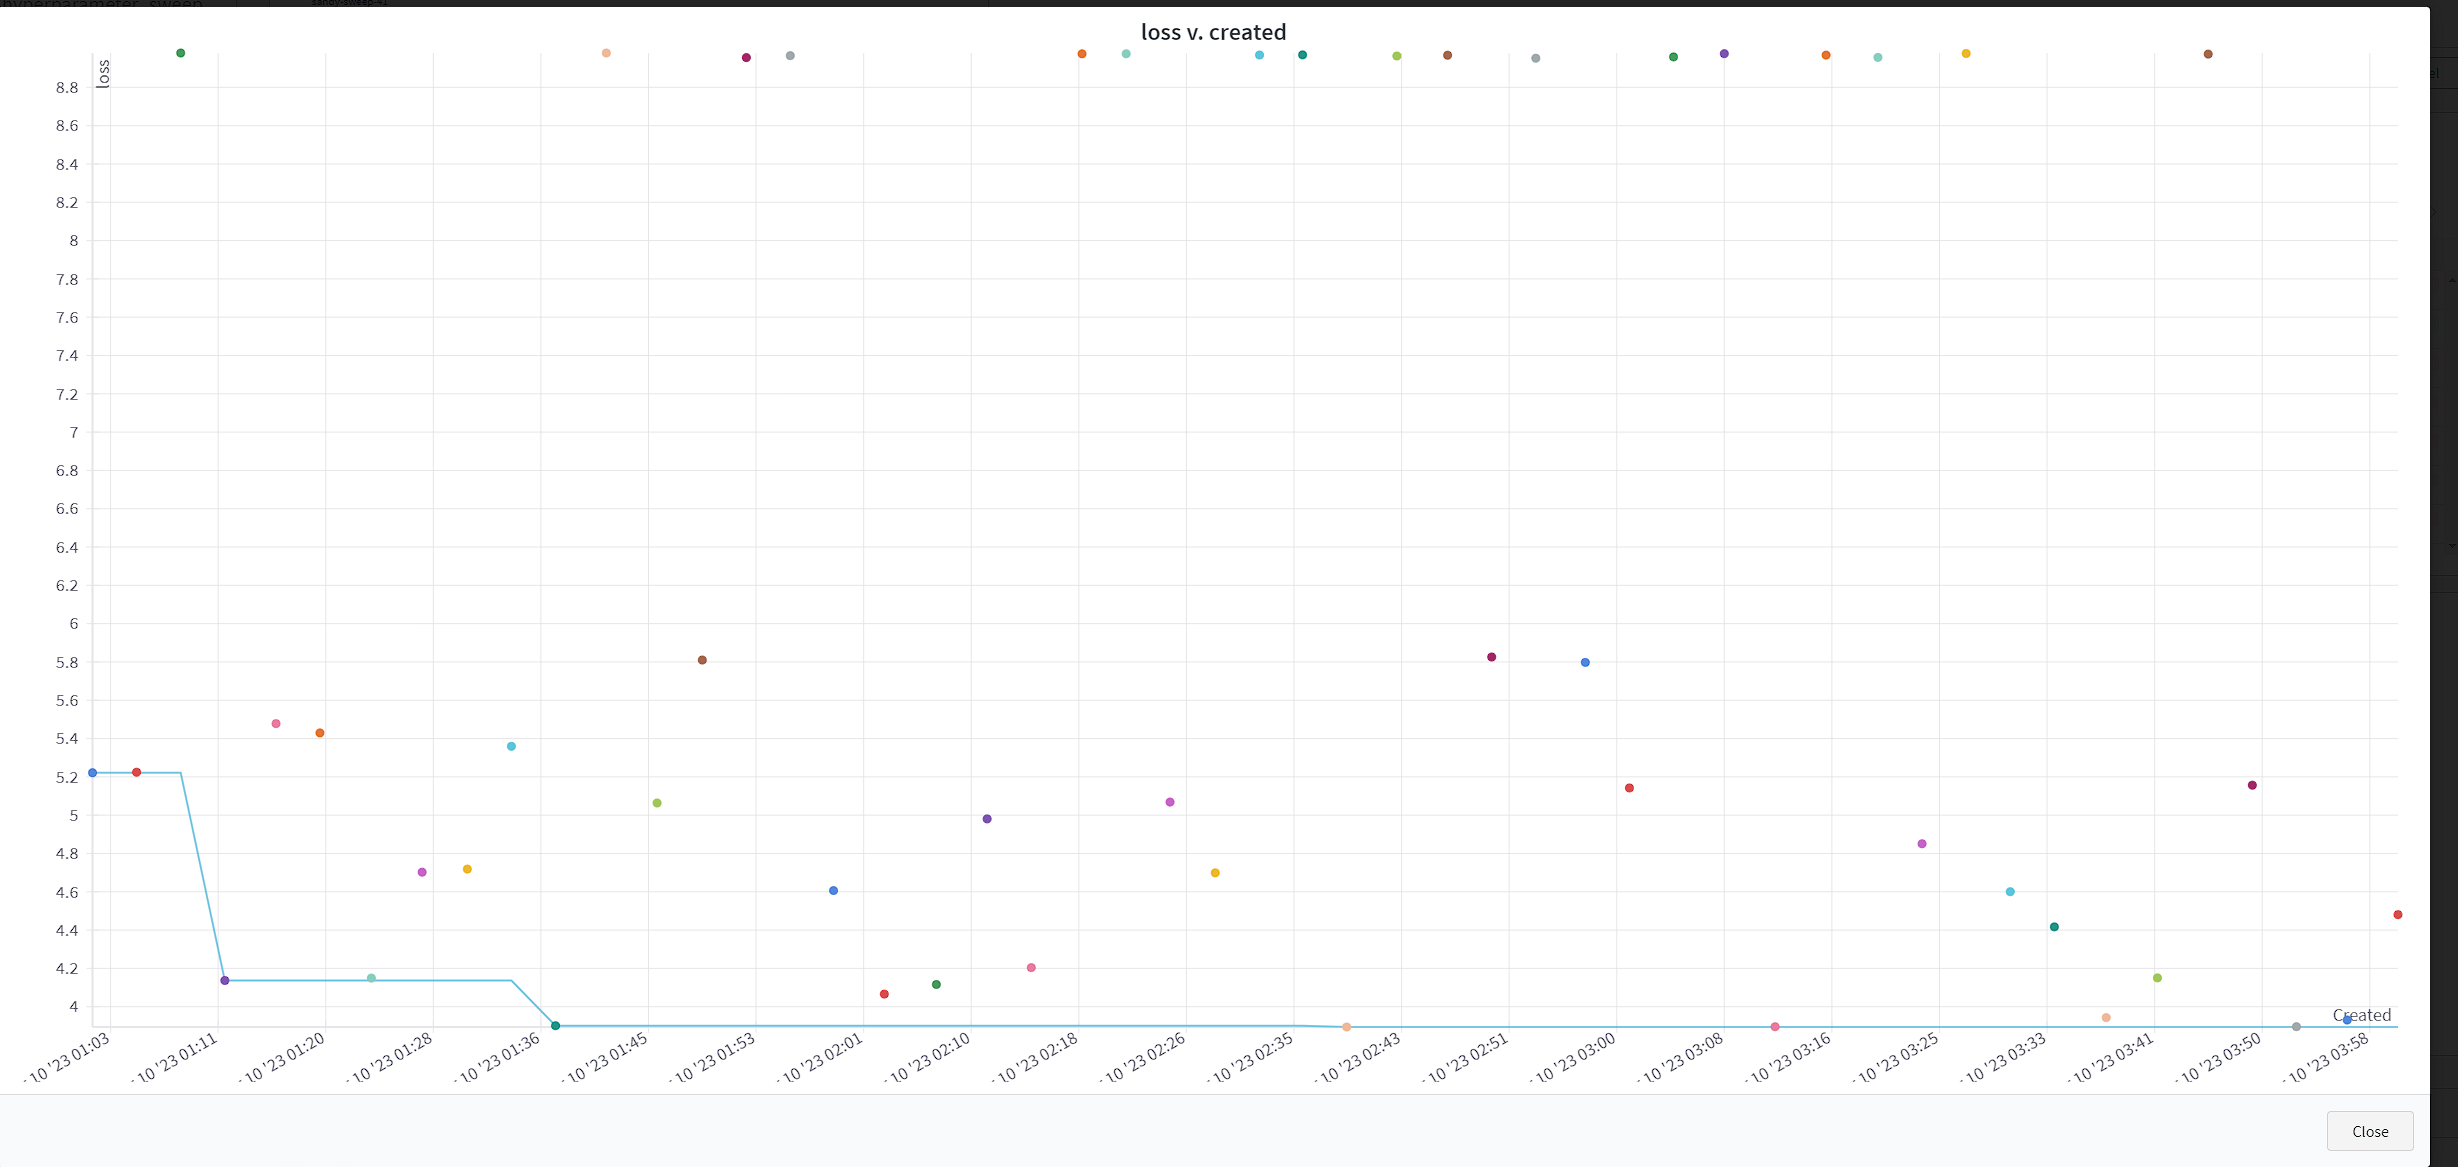

***HYPERPARAMETER SWEEP***

The best hyperparameters were clip: 100, decoder_learning_ratio: 5,

teacher_forcing_ratio: 0, learning_rate: 0.00025, optimzer: adam for a loss of 3.901


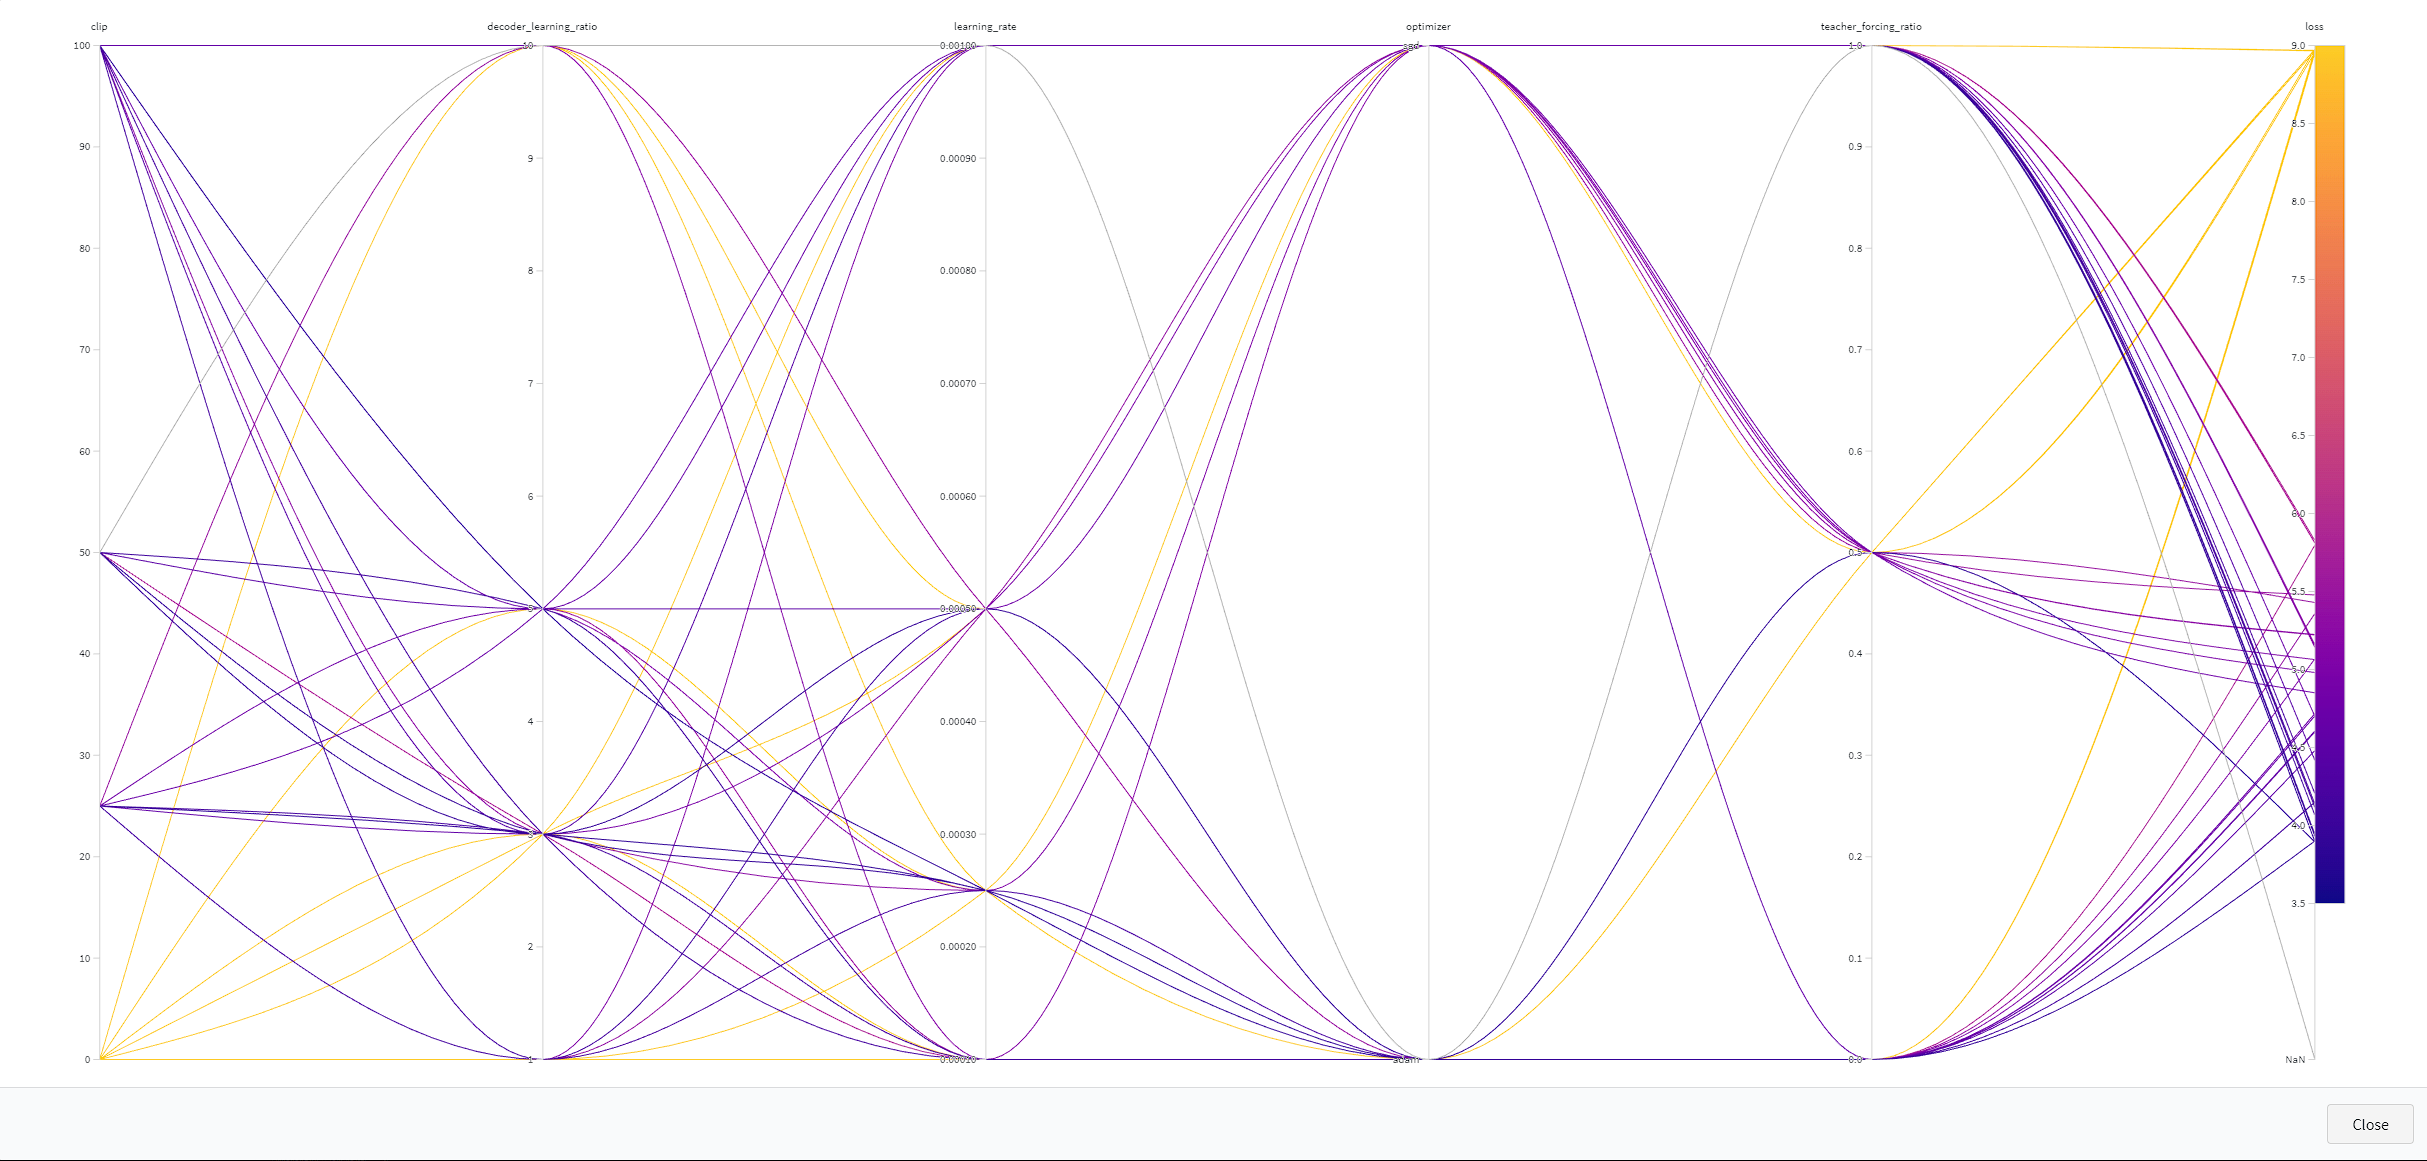

***Q.6***

In [22]:
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity


with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):

      
      # Configure models , Configure training/optimization
      model_name = 'cb_model_bestloss'
      attn_model = 'dot'
      hidden_size = 500
      encoder_n_layers = 2
      decoder_n_layers = 2
      dropout = 0.1
      batch_size = 64
      learning_rate = 0.00025
      clip =100
      teacher_forcing_ratio =0
      decoder_learning_ratio =5
      n_iteration = 4000
      print_every = 500





      # Initialize word embeddings
      embedding = nn.Embedding(voc.num_words, hidden_size)

      # Initialize encoder & decoder models
      encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
      decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

      # Use appropriate device
      encoder = encoder.to(device)
      decoder = decoder.to(device)
    





      encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
      decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


      # If you have cuda, configure cuda to call
      for state in encoder_optimizer.state.values():
          for k, v in state.items():
              if isinstance(v, torch.Tensor):
                  state[k] = v.cuda()

      for state in decoder_optimizer.state.values():
          for k, v in state.items():
              if isinstance(v, torch.Tensor):
                  state[k] = v.cuda()

      # Set dropout layers to eval mode
      encoder.eval()
      decoder.eval()

      # Initialize search module
      searcher = GreedySearchDecoder(encoder, decoder)

      # Begin chatting (uncomment and run the following line to begin)
      evaluateInput(encoder, decoder, searcher, voc)


> hi
Bot: yell kicked kicked kind pumpkin riders examined limb examined indeed
> quit


In [23]:
#Time Consumption
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))    


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        88.25%        6.869s       100.00%        7.784s        7.784s       0.000us         0.00%      20.653ms      20.653ms           0 b     -71.95 Mb      81.04 Mb    -946.50 K

In [24]:
#Memory Consumption
print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.02%       1.197ms         0.02%       1.769ms      10.988us       0.000us         0.00%       0.000us       0.000us      71.95 Mb      71.95 Mb     395.51 Mb     395.51 M

***Q.7***

In [25]:
prof.export_chrome_trace("trace.json")

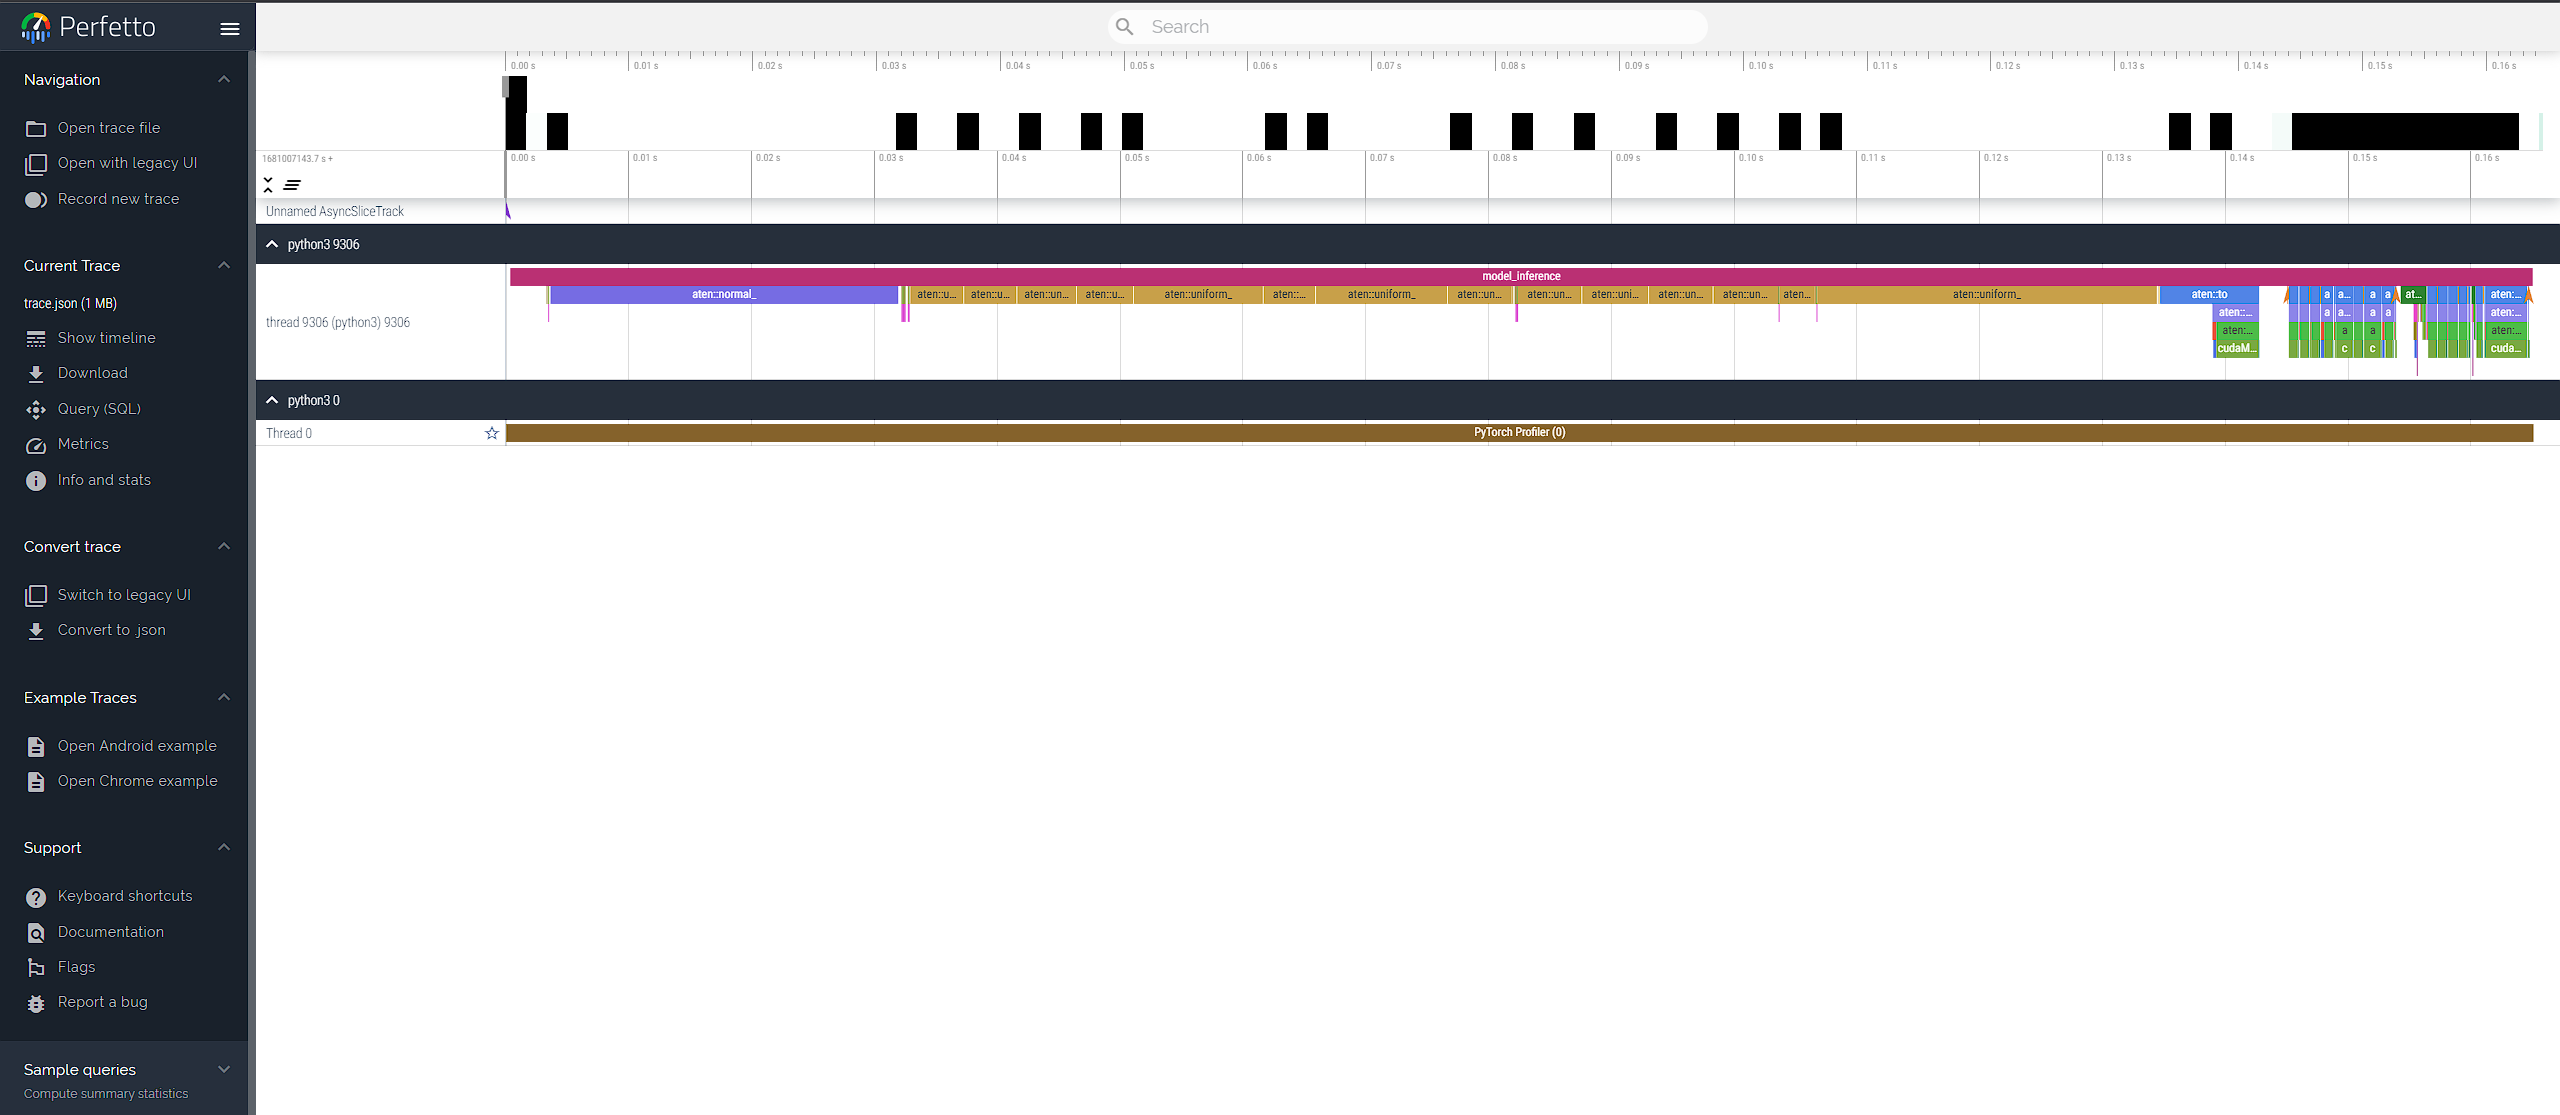

 ***Q.8***

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Configure models , Configure training/optimization
model_name = 'cb_model_BEST_LOSS'
attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
learning_rate = 0.00025

clip =100
teacher_forcing_ratio =0
decoder_learning_ratio =5
n_iteration = 4000
print_every = 1000
save_every = 4000
loadFilename = None

print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()




# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)


# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)



Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1000; Percent complete: 25.0%; Average loss: 4.7342
Iteration: 2000; Percent complete: 50.0%; Average loss: 4.3878
Iteration: 3000; Percent complete: 75.0%; Average loss: 4.0849
Iteration: 4000; Percent complete: 100.0%; Average loss: 3.7478


4.238691599317135

As we can see the average loss of 3.7478 at 4000 iterations is around the same loss range we got in the hyperparameter sweep

**PROBLEM2**

**Q.1**

In PyTorch, tracing and scripting are two ways to convert PyTorch models into TorchScript, which is a high-performance serialization and deployment format for PyTorch models.

Tracing involves recording the operations performed by a PyTorch model during a forward pass on a set of inputs. This creates a trace of the model's execution as a graph structure, which can be saved as a TorchScript file. This approach is useful when the model has a fixed input shape and the control flow is static, which is typical for many deep learning models. Tracing is often used for models that are used for inference, and not trained further.

Scripting involves writing the PyTorch model as a script using Python syntax, and then converting it into TorchScript. This approach is useful when the model has a dynamic input shape, and the control flow is more complex, with conditional statements and loops. In scripting, one can use Python's control flow constructs, and the resulting script can be converted to TorchScript. Scripting is often used for models that require further training, such as reinforcement learning or transfer learning.

TorchScript allows combining tracing and scripting to leverage their respective strengths and optimize the performance of PyTorch models. Tracing optimizes the performance of the static parts of the model, while scripting handles the dynamic parts of the model. TorchScript is a powerful tool for optimizing PyTorch models for deployment on various platforms, including mobile devices and cloud-based servers.

**Q.2**

The chatbot model is based on a sequence-to-sequence (Seq2Seq) model using an encoder-decoder architecture with attention. To enable scripting in this chatbot model, we need to make the following changes:

1. ***Convert the model to use CPU instead of GPU***: To allow for scripting, the model needs to be moved from GPU to CPU. This can be done by calling the to('cpu') method on the model and its associated tensors.

2. ***Trace the encoder and decoder models***: The encoder and decoder models need to be traced using the torch.jit.trace function. This function takes a model and a set of example inputs, and creates a scriptable version of the model. In this case, the example inputs are a sequence of words and its associated length.

3. ***Modify the searcher module***: The searcher module needs to be modified to use the scriptable encoder and decoder models. This can be done by passing the traced encoder and decoder models to the GreedySearchDecoder constructor. The GreedySearchDecoder module takes care of running the encoder and decoder models in sequence, using the output of the encoder as input to the decoder.

4. ***Wrap the searcher module in a script***: The final step is to wrap the searcher module in a torch.jit.script call, which creates a scriptable version of the searcher module. This allows the entire chatbot model to be run in a scripted mode, which provides faster inference and allows the model to be deployed in production environments.

Overall, these changes enable the chatbot model to be converted into a scriptable format, which can be run on a CPU and deployed in production environments.

***Q.3***

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [29]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [30]:
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [31]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, decoder_n_layers):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._device = device
        self._SOS_token = SOS_token
        self._decoder_n_layers = decoder_n_layers

    __constants__ = ['_device', '_SOS_token', '_decoder_n_layers']

    def forward(self, input_seq : torch.Tensor, input_length : torch.Tensor, max_length : int):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self._decoder_n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=self._device, dtype=torch.long) * self._SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=self._device, dtype=torch.long)
        all_scores = torch.zeros([0], device=self._device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [32]:
def evaluate(searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


# Evaluate inputs from user input (stdin)
def evaluateInput(searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

# Normalize input sentence and call evaluate()
def evaluateExample(sentence, searcher, voc):
    print("> " + sentence)
    # Normalize sentence
    input_sentence = normalizeString(sentence)
    # Evaluate sentence
    output_words = evaluate(searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    print('Bot:', ' '.join(output_words))

In [41]:
# Set checkpoint to load from; set to None if starting from scratch
loadFilename = "/content/drive/MyDrive/data/save/cb_model_BEST_LOSS/movie-corpus/2-2_500/4000_checkpoint.tar"
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))

model_name = 'cb_model_BEST_LOSS'
attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
learning_rate = 0.00025

clip =100
teacher_forcing_ratio =0
decoder_learning_ratio =5
n_iteration = 4000
print_every = 500
save_every = 500
# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Set dropout layers to eval mode
encoder.eval()
decoder.eval()
print('Models built and ready to go!')



Building encoder and decoder ...
Models built and ready to go!


In [42]:
### Compile the whole greedy search model to TorchScript model
# Create artificial inputs
test_seq = torch.LongTensor(MAX_LENGTH, 1).random_(0, voc.num_words).to(device)
test_seq_length = torch.LongTensor([test_seq.size()[0]]).to(device)
# Trace the model
traced_encoder = torch.jit.trace(encoder, (test_seq, test_seq_length.to('cpu')))

### Convert decoder model
# Create and generate artificial inputs
test_encoder_outputs, test_encoder_hidden = traced_encoder(test_seq, test_seq_length)
test_decoder_hidden = test_encoder_hidden[:decoder.n_layers]
test_decoder_input = torch.LongTensor(1, 1).random_(0, voc.num_words)
# Trace the model
traced_decoder = torch.jit.trace(decoder, (test_decoder_input.to(device), test_decoder_hidden, test_encoder_outputs.to(device)))

### Initialize searcher module by wrapping ``torch.jit.script`` call
scripted_searcher = torch.jit.script(GreedySearchDecoder(traced_encoder, traced_decoder, decoder.n_layers))

***Q.4***

In [43]:
print('scripted_searcher graph:\n', scripted_searcher.graph)

scripted_searcher graph:
 graph(%self : __torch__.___torch_mangle_33.GreedySearchDecoder,
      %input_seq.1 : Tensor,
      %input_length.1 : Tensor,
      %max_length.1 : int):
  %53 : bool = prim::Constant[value=0]()
  %42 : bool = prim::Constant[value=1]() # <ipython-input-31-7c45bc0b22de>:23:8
  %18 : int = prim::Constant[value=4]() # <ipython-input-31-7c45bc0b22de>:18:68
  %17 : Device = prim::Constant[value="cuda"]() # <ipython-input-31-7c45bc0b22de>:18:48
  %14 : NoneType = prim::Constant()
  %12 : int = prim::Constant[value=2]() # <ipython-input-31-7c45bc0b22de>:16:41
  %16 : int = prim::Constant[value=1]() # <ipython-input-31-7c45bc0b22de>:18:35
  %26 : int = prim::Constant[value=0]() # <ipython-input-31-7c45bc0b22de>:20:34
  %encoder : __torch__.___torch_mangle_15.EncoderRNN = prim::GetAttr[name="encoder"](%self)
  %7 : (Tensor, Tensor) = prim::CallMethod[name="forward"](%encoder, %input_seq.1, %input_length.1) # <ipython-input-31-7c45bc0b22de>:14:42
  %encoder_outputs.1 : T

***Q.5***

In [44]:
# Use appropriate device
scripted_searcher.to(device)
# Set dropout layers to eval mode
scripted_searcher.eval()

# Evaluate examples
sentences = ["hello", "what's up?", "who are you?", "where am I?", "where are you from?"]
for s in sentences:
    evaluateExample(s, scripted_searcher, voc)

# Evaluate your input
#evaluateInput(traced_encoder, traced_decoder, scripted_searcher, voc)

> hello
Bot: hello . .
> what's up?
Bot: shhhh shark shark the tank shark shark tank .
> who are you?
Bot: i parole the . . .
> where am I?
Bot: in . . .
> where are you from?
Bot: san .


***Q.6***

In [45]:

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):

      # Use appropriate device
      scripted_searcher.to(device)
      # Set dropout layers to eval mode
      scripted_searcher.eval()
      # Evaluate examples
      sentences = ["hello", "what's up?", "who are you?", "where am I?", "where are you from?"]
      for s in sentences:
          evaluateExample(s, scripted_searcher, voc)

> hello
Bot: hello . .
> what's up?
Bot: shhhh shark shark the tank shark shark tank .
> who are you?
Bot: i parole the . . .
> where am I?
Bot: in . . .
> where are you from?
Bot: san .


In [46]:
#Time Consumption
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))  

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        11.88%      10.578ms        99.95%      89.031ms      89.031ms       0.000us         0.00%      21.397ms      21.397ms           0 b        -320 b           0 b      -4.09 M

***Q.7***

In [47]:
scripted_searcher.save("scripted_chatbot.pth")